Cell 1: Setup

In [5]:
# Setup - Run this first
!pip install torch matplotlib seaborn pandas numpy scikit-learn tqdm -q

import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

os.makedirs('data/raw', exist_ok=True)
print("Setup complete!")

Using device: cuda
Setup complete!


Cell 2: Upload Data

In [6]:
import zipfile
import urllib.request
import os
from pathlib import Path

def check_data_files():
    """Check if required files already exist"""
    required_files = ['studentInfo.csv', 'studentVle.csv', 'studentAssessment.csv']
    existing = []
    missing = []

    for file in required_files:
        if os.path.exists(f'data/raw/{file}'):
            existing.append(file)
        else:
            missing.append(file)

    if existing:
        print(f"✅ Found existing files: {existing}")
    if missing:
        print(f"❌ Missing files: {missing}")

    return len(missing) == 0

def download_oulad_dataset():
    """Attempt to automatically download OULAD dataset"""
    print("🔄 Attempting to download OULAD dataset...")

    try:
        # Download URL (Kaggle public dataset)
        url = "https://www.kaggle.com/api/v1/datasets/download/anlgrbz/student-demographics-online-education-dataoulad"
        zip_path = "oulad_dataset.zip"

        print("📥 Downloading dataset (this may take a few minutes)...")

        # Try using curl first (more reliable for large files)
        try:
            import subprocess
            result = subprocess.run([
                'curl', '-L', '-o', zip_path, url
            ], capture_output=True, text=True, timeout=300)  # 5 minute timeout

            if result.returncode != 0:
                raise Exception(f"Curl failed: {result.stderr}")

        except (subprocess.TimeoutExpired, FileNotFoundError, Exception) as e:
            print(f"⚠️ Curl method failed: {e}")
            print("📥 Trying alternative download method...")

            # Fallback to urllib
            urllib.request.urlretrieve(url, zip_path)

        # Check if download was successful
        if not os.path.exists(zip_path) or os.path.getsize(zip_path) < 1000:  # Less than 1KB indicates failure
            raise Exception("Downloaded file is too small or doesn't exist")

        file_size_mb = os.path.getsize(zip_path) / (1024 * 1024)
        print(f"✅ Download complete: {file_size_mb:.1f} MB")

        # Extract the zip file
        print("📂 Extracting files...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # List all files in the zip
            all_files = zip_ref.namelist()
            print(f"Found {len(all_files)} files in archive")

            required_files = ['studentInfo.csv', 'studentVle.csv', 'studentAssessment.csv']
            extracted_files = []

            # Extract required files
            for file_path in all_files:
                filename = os.path.basename(file_path)

                if filename in required_files:
                    # Read file data from zip
                    with zip_ref.open(file_path) as source:
                        # Write to data/raw/
                        target_path = f'data/raw/{filename}'
                        with open(target_path, 'wb') as target:
                            target.write(source.read())

                    extracted_files.append(filename)
                    file_size = os.path.getsize(target_path) / (1024 * 1024)
                    print(f"  ✅ Extracted {filename}: {file_size:.1f} MB")

            # Check if all required files were found
            missing_files = [f for f in required_files if f not in extracted_files]
            if missing_files:
                raise Exception(f"Required files not found in archive: {missing_files}")

        # Clean up zip file
        os.remove(zip_path)
        print("🗑️ Cleaned up temporary files")

        print("🎉 Automatic download completed successfully!")
        return True

    except Exception as e:
        print(f"❌ Automatic download failed: {str(e)}")

        # Clean up failed download
        if os.path.exists(zip_path):
            try:
                os.remove(zip_path)
            except:
                pass

        return False

def manual_upload():
    """Fallback to manual file upload"""
    print("\n📤 Please upload the OULAD CSV files manually:")
    print("   Required files: studentInfo.csv, studentVle.csv, studentAssessment.csv")
    print("   Download from: https://www.kaggle.com/datasets/anlgrbz/student-demographics-online-education-dataoulad")

    try:
        from google.colab import files
        print("\n⬇️ Click 'Choose Files' below and select all 3 CSV files:")
        uploaded = files.upload()

        moved_files = []
        for filename in uploaded.keys():
            if filename.endswith('.csv'):
                # Move to data/raw/
                target_path = f'data/raw/{filename}'
                os.rename(filename, target_path)

                file_size = os.path.getsize(target_path) / (1024 * 1024)
                print(f"✅ Uploaded {filename}: {file_size:.1f} MB")
                moved_files.append(filename)

        if len(moved_files) == 3:
            print("🎉 Manual upload completed successfully!")
            return True
        else:
            print(f"⚠️ Only {len(moved_files)} files uploaded. Need 3 files.")
            return False

    except ImportError:
        print("❌ Manual upload not available (not running in Colab)")
        print("Please manually place CSV files in data/raw/ directory")
        return False
    except Exception as e:
        print(f"❌ Manual upload failed: {e}")
        return False

# Main execution
print("🔍 Checking for existing data files...")

if check_data_files():
    print("✅ All required data files already exist! Skipping download.")
else:
    print("\n🚀 Starting data acquisition process...")

    # Try automatic download first
    download_success = download_oulad_dataset()

    if not download_success:
        print("\n🔄 Automatic download failed. Trying manual upload...")
        upload_success = manual_upload()

        if not upload_success:
            print("\n❌ Both automatic and manual methods failed.")
            print("📋 Manual steps:")
            print("1. Go to: https://www.kaggle.com/datasets/anlgrbz/student-demographics-online-education-dataoulad")
            print("2. Download the dataset")
            print("3. Extract and upload the 3 CSV files using the file browser on the left")
            print("4. Place them in the data/raw/ folder")

    # Final check
    print("\n🔍 Final verification...")
    if check_data_files():
        print("🎉 All data files are ready!")

        # Show file info
        required_files = ['studentInfo.csv', 'studentVle.csv', 'studentAssessment.csv']
        print("\n📊 Dataset info:")
        total_size = 0
        for filename in required_files:
            filepath = f'data/raw/{filename}'
            if os.path.exists(filepath):
                size_mb = os.path.getsize(filepath) / (1024 * 1024)
                total_size += size_mb
                print(f"   📄 {filename}: {size_mb:.1f} MB")

        print(f"   💾 Total size: {total_size:.1f} MB")
        print("\n✅ Ready to proceed to next cell!")
    else:
        print("❌ Data files still missing. Please upload manually.")

🔍 Checking for existing data files...
✅ Found existing files: ['studentInfo.csv', 'studentVle.csv', 'studentAssessment.csv']
✅ All required data files already exist! Skipping download.


Cell 3: Load and Process Data

In [7]:
def load_and_process_oulad():
    # Load CSV files
    print("Loading OULAD data...")
    student_info = pd.read_csv('data/raw/studentInfo.csv')
    student_vle = pd.read_csv('data/raw/studentVle.csv')
    student_assessment = pd.read_csv('data/raw/studentAssessment.csv')

    print(f"Loaded: Info={student_info.shape}, VLE={student_vle.shape}, Assessment={student_assessment.shape}")
    print(f"VLE columns: {list(student_vle.columns)}")
    print(f"Assessment columns: {list(student_assessment.columns)}")

    # Handle date columns flexibly
    vle_date_col = 'date' if 'date' in student_vle.columns else student_vle.columns[1]
    student_vle['week'] = student_vle[vle_date_col] // 7

    # Handle assessment dates
    if 'date_submitted' in student_assessment.columns:
        student_assessment['week'] = student_assessment['date_submitted'] // 7
    elif 'date' in student_assessment.columns:
        student_assessment['week'] = student_assessment['date'] // 7
    else:
        student_assessment['week'] = 0
        print("Warning: No date column found in assessments")

    # Handle click columns
    click_col = 'sum_click' if 'sum_click' in student_vle.columns else 'clicks'

    # Aggregate clicks per week
    clicks_df = student_vle.groupby(['id_student', 'week'])[click_col].sum().reset_index()
    clicks_df.columns = ['id_student', 'week', 'clicks']

    # Handle assessment scores
    if 'score' in student_assessment.columns:
        # Convert text scores to numeric if needed
        if student_assessment['score'].dtype == 'object':
            score_map = {'Pass': 70, 'Fail': 30, 'Distinction': 85, 'Withdrawn': 0}
            student_assessment['score'] = student_assessment['score'].map(score_map).fillna(0)

        submit_df = student_assessment.groupby(['id_student', 'week'])['score'].agg(['count', 'mean']).reset_index()
        submit_df.columns = ['id_student', 'week', 'submit_cnt', 'avg_score']
    else:
        submit_df = pd.DataFrame(columns=['id_student', 'week', 'submit_cnt', 'avg_score'])

    # Create complete time grid for all students
    all_students = student_info['id_student'].unique()
    all_weeks = []
    for student in all_students:
        for week in range(30):  # 30 weeks max
            all_weeks.append({'id_student': student, 'week': week})

    df = pd.DataFrame(all_weeks)

    # Merge features
    df = df.merge(clicks_df, on=['id_student', 'week'], how='left')
    if not submit_df.empty:
        df = df.merge(submit_df, on=['id_student', 'week'], how='left')
    else:
        df['submit_cnt'] = 0
        df['avg_score'] = 0

    # Fill missing values
    df.fillna(0, inplace=True)
    df = df.sort_values(['id_student', 'week']).reset_index(drop=True)

    # Create derived features
    df['has_submit'] = (df['submit_cnt'] > 0).astype(int)
    df['avg_score_sofar'] = df.groupby('id_student')['avg_score'].expanding().mean().values
    df['clicks_diff1'] = df.groupby('id_student')['clicks'].diff().fillna(0)

    print(f"Created weekly features: {df.shape}")
    print(f"Average clicks per week: {df['clicks'].mean():.1f}")

    return df

weekly_df = load_and_process_oulad()

Loading OULAD data...
Loaded: Info=(32593, 12), VLE=(10655280, 6), Assessment=(173912, 5)
VLE columns: ['code_module', 'code_presentation', 'id_student', 'id_site', 'date', 'sum_click']
Assessment columns: ['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score']
Created weekly features: (863550, 8)
Average clicks per week: 38.0


Cell 4: Create Sequences

In [8]:
def create_sequences(df, input_weeks=4, output_weeks=2):
    """Create input-output sequences"""
    feature_cols = ['clicks', 'has_submit', 'avg_score_sofar', 'clicks_diff1']

    X_list = []
    y_list = []
    student_list = []

    print("Creating sequences...")
    for student_id, group in tqdm(df.groupby('id_student')):
        group = group.sort_values('week').reset_index(drop=True)

        if len(group) < input_weeks + output_weeks:
            continue

        for i in range(len(group) - input_weeks - output_weeks + 1):
            # Input: 4 weeks of 4 features
            X_window = group.iloc[i:i+input_weeks][feature_cols].values
            # Output: 2 weeks of clicks only
            y_window = group.iloc[i+input_weeks:i+input_weeks+output_weeks][['clicks']].values

            X_list.append(X_window)
            y_list.append(y_window)
            student_list.append(student_id)

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    student_ids = np.array(student_list)

    print(f"Created {len(X)} sequences")
    print(f"Input shape: {X.shape}")
    print(f"Output shape: {y.shape}")

    return X, y, student_ids

def split_and_normalize(X, y, student_ids):
    """Split by students and normalize"""
    print("Splitting data by student ID...")

    # Split by student to avoid data leakage
    unique_students = np.unique(student_ids)
    train_students, test_students = train_test_split(unique_students, test_size=0.2, random_state=42)
    train_students, val_students = train_test_split(train_students, test_size=0.1, random_state=42)

    train_mask = np.isin(student_ids, train_students)
    val_mask = np.isin(student_ids, val_students)
    test_mask = np.isin(student_ids, test_students)

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Normalize using training statistics only
    X_mean = X_train.mean(axis=(0, 1), keepdims=True)
    X_std = X_train.std(axis=(0, 1), keepdims=True) + 1e-8
    y_mean = y_train.mean()
    y_std = y_train.std() + 1e-8

    X_train = (X_train - X_mean) / X_std
    X_val = (X_val - X_mean) / X_std
    X_test = (X_test - X_mean) / X_std

    y_train = (y_train - y_mean) / y_std
    y_val = (y_val - y_mean) / y_std
    y_test = (y_test - y_mean) / y_std

    print("Data normalized successfully")

    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'norm_stats': {'y_mean': y_mean, 'y_std': y_std}
    }

# Create sequences and split data
X, y, student_ids = create_sequences(weekly_df)
data = split_and_normalize(X, y, student_ids)

Creating sequences...


100%|██████████| 28785/28785 [10:33<00:00, 45.47it/s]


Created 719625 sequences
Input shape: (719625, 4, 4)
Output shape: (719625, 2, 1)
Splitting data by student ID...
Train: 518125, Val: 57575, Test: 143925
Data normalized successfully


Cell 5: Define Models

In [9]:
class LearningBehaviorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(output_size, hidden_size, batch_first=True)
        self.output_proj = nn.Linear(hidden_size, output_size)

    def forward(self, x, tgt_len):
        batch_size = x.size(0)

        # Encode
        _, (hidden, cell) = self.encoder(x)

        # Decode
        decoder_input = torch.zeros(batch_size, 1, self.output_size, device=x.device)
        outputs = []

        for t in range(tgt_len):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            output = self.output_proj(decoder_output)
            outputs.append(output)
            decoder_input = output

        return torch.cat(outputs, dim=1)

class Seq2SeqVAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_dim, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.output_size = output_size

        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.mu_proj = nn.Linear(hidden_size, latent_dim)
        self.logvar_proj = nn.Linear(hidden_size, latent_dim)

        self.decoder = nn.LSTM(output_size + latent_dim, hidden_size, batch_first=True)
        self.output_proj = nn.Linear(hidden_size, output_size)

    def encode(self, x):
        _, (hidden, _) = self.encoder(x)
        mu = self.mu_proj(hidden[-1])
        logvar = self.logvar_proj(hidden[-1])
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, tgt_len):
        batch_size = z.size(0)
        decoder_input = torch.zeros(batch_size, 1, self.output_size, device=z.device)
        z_expanded = z.unsqueeze(1)

        outputs = []
        hidden = None

        for t in range(tgt_len):
            decoder_input_with_z = torch.cat([decoder_input, z_expanded], dim=-1)
            decoder_output, hidden = self.decoder(decoder_input_with_z, hidden)
            output = self.output_proj(decoder_output)
            outputs.append(output)
            decoder_input = output

        return torch.cat(outputs, dim=1)

    def forward(self, x, tgt_len):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, tgt_len)
        return recon, mu, logvar

print("Models defined successfully!")

print("\n📦 Creating DataLoaders...")

train_dataset = LearningBehaviorDataset(data['X_train'], data['y_train'])
val_dataset = LearningBehaviorDataset(data['X_val'], data['y_val'])
test_dataset = LearningBehaviorDataset(data['X_test'], data['y_test'])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"✅ DataLoaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

Models defined successfully!

📦 Creating DataLoaders...
✅ DataLoaders created:
   Train batches: 4048
   Val batches: 450
   Test batches: 1125


Cell 6: Train Models

In [10]:
# Train LSTM with history tracking
print("\n🚀 Training LSTM...")
lstm_model = Seq2SeqLSTM(input_size=4, hidden_size=64, output_size=1).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)

lstm_train_losses = []
lstm_val_losses = []

for epoch in range(20):
    # Training
    lstm_model.train()
    total_train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = lstm_model(X_batch, 2)
        loss = F.mse_loss(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    lstm_train_losses.append(avg_train_loss)

    # Validation
    lstm_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = lstm_model(X_batch, 2)
            loss = F.mse_loss(outputs, y_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    lstm_val_losses.append(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(
            f"LSTM Epoch {epoch + 1}/20: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}"
        )

print("✅ LSTM training completed!")

# Train VAE with history tracking
print("\n🚀 Training VAE...")
vae_model = Seq2SeqVAE(input_size=4, hidden_size=64, latent_dim=16, output_size=1).to(
    device
)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
beta = 1.0

vae_train_losses = []
vae_val_losses = []
vae_train_mse = []
vae_train_kld = []

for epoch in range(20):
    # Training
    vae_model.train()
    total_train_loss = 0
    total_mse = 0
    total_kld = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = vae_model(X_batch, 2)

        mse_loss = F.mse_loss(recon, y_batch)
        kl_loss = (
            -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / y_batch.numel()
        )
        loss = mse_loss + beta * kl_loss

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_mse += mse_loss.item()
        total_kld += kl_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_mse = total_mse / len(train_loader)
    avg_kld = total_kld / len(train_loader)

    vae_train_losses.append(avg_train_loss)
    vae_train_mse.append(avg_mse)
    vae_train_kld.append(avg_kld)

    # Validation
    vae_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            recon, mu, logvar = vae_model(X_batch, 2)
            mse_loss = F.mse_loss(recon, y_batch)
            kl_loss = (
                -0.5
                * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                / y_batch.numel()
            )
            loss = mse_loss + beta * kl_loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    vae_val_losses.append(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(
            f"VAE Epoch {epoch + 1}/20: Train Loss = {avg_train_loss:.6f} (MSE={avg_mse:.6f}, KLD={avg_kld:.6f}), Val Loss = {avg_val_loss:.6f}"
        )

print("✅ VAE training completed!")


🚀 Training LSTM...
LSTM Epoch 5/20: Train Loss = 0.621173, Val Loss = 0.577992
LSTM Epoch 10/20: Train Loss = 0.614324, Val Loss = 0.573063
LSTM Epoch 15/20: Train Loss = 0.606603, Val Loss = 0.573735
LSTM Epoch 20/20: Train Loss = 0.596072, Val Loss = 0.579187
✅ LSTM training completed!

🚀 Training VAE...
VAE Epoch 5/20: Train Loss = 0.907435 (MSE=0.798810, KLD=0.108625), Val Loss = 0.880329
VAE Epoch 10/20: Train Loss = 0.903244 (MSE=0.794457, KLD=0.108786), Val Loss = 0.879610
VAE Epoch 15/20: Train Loss = 0.899993 (MSE=0.789691, KLD=0.110303), Val Loss = 0.883637
VAE Epoch 20/20: Train Loss = 0.892107 (MSE=0.782972, KLD=0.109135), Val Loss = 0.884071
✅ VAE training completed!


CELL 7: Visualization 1 - Training Curves

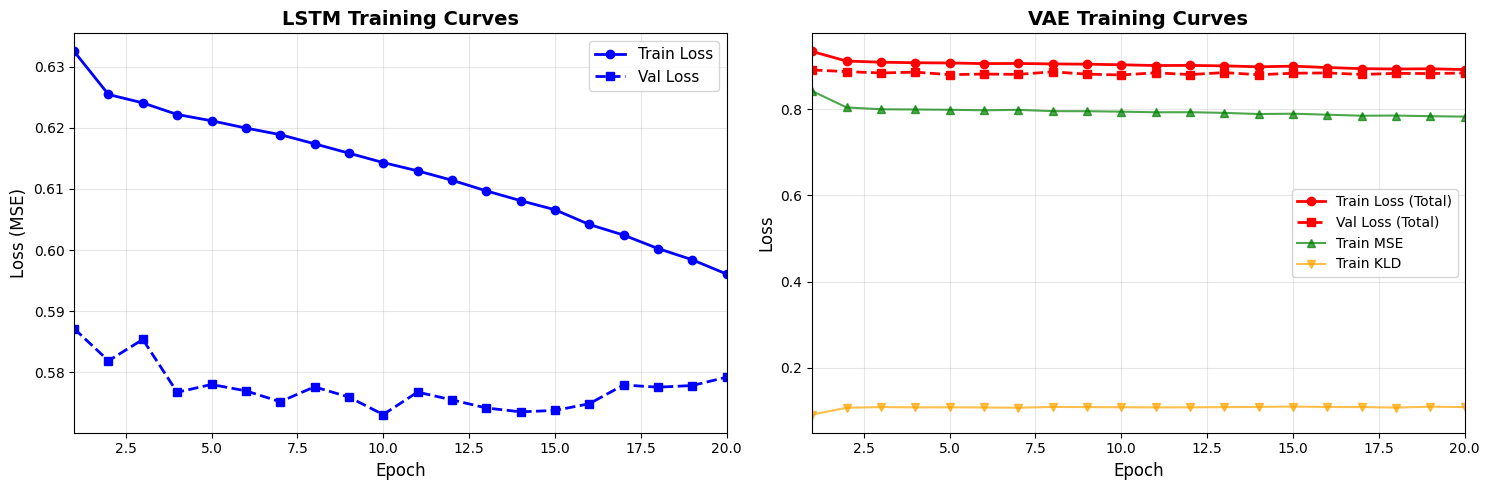

📊 Training curves saved as 'training_curves.png'


In [11]:
"""Visualization 1: Training Curves"""

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# LSTM Training Curve
axes[0].plot(
    range(1, 21), lstm_train_losses, "b-", linewidth=2, label="Train Loss", marker="o"
)
axes[0].plot(
    range(1, 21), lstm_val_losses, "b--", linewidth=2, label="Val Loss", marker="s"
)
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Loss (MSE)", fontsize=12)
axes[0].set_title("LSTM Training Curves", fontsize=14, fontweight="bold")
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(1, 20)

# VAE Training Curve
axes[1].plot(
    range(1, 21),
    vae_train_losses,
    "r-",
    linewidth=2,
    label="Train Loss (Total)",
    marker="o",
)
axes[1].plot(
    range(1, 21),
    vae_val_losses,
    "r--",
    linewidth=2,
    label="Val Loss (Total)",
    marker="s",
)
axes[1].plot(
    range(1, 21),
    vae_train_mse,
    "g-",
    linewidth=1.5,
    alpha=0.7,
    label="Train MSE",
    marker="^",
)
axes[1].plot(
    range(1, 21),
    vae_train_kld,
    "orange",
    linewidth=1.5,
    alpha=0.7,
    label="Train KLD",
    marker="v",
)
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Loss", fontsize=12)
axes[1].set_title("VAE Training Curves", fontsize=14, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(1, 20)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 Training curves saved as 'training_curves.png'")

Cell 8: Evaluate and Compare

In [12]:
"""Cell 8: Evaluate and Compare with Detailed Analysis"""

def evaluate_models_detailed():
    lstm_model.eval()
    vae_model.eval()

    lstm_predictions = []
    vae_predictions = []
    vae_samples = []
    targets = []

    print("Evaluating models...")

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            lstm_pred = lstm_model(X_batch, 2)
            lstm_predictions.append(lstm_pred.cpu().numpy())

            vae_pred, _, _ = vae_model(X_batch, 2)
            vae_predictions.append(vae_pred.cpu().numpy())

            mu, logvar = vae_model.encode(X_batch)
            batch_samples = []
            for _ in range(20):
                z = vae_model.reparameterize(mu, logvar)
                sample = vae_model.decode(z, 2)
                batch_samples.append(sample.cpu().numpy())
            vae_samples.append(np.array(batch_samples))

            targets.append(y_batch.cpu().numpy())

    lstm_preds = np.concatenate(lstm_predictions)
    vae_preds = np.concatenate(vae_predictions)
    vae_samples = np.concatenate(vae_samples, axis=1)
    all_targets = np.concatenate(targets)

    # Calculate per-sample MSE
    lstm_mse_per_sample = np.mean((lstm_preds - all_targets) ** 2, axis=(1, 2))
    vae_mse_per_sample = np.mean((vae_preds - all_targets) ** 2, axis=(1, 2))

    # VAE Best-of-N per sample
    vae_best_mse_per_sample = []
    for i in range(len(all_targets)):
        sample_mses = []
        for j in range(20):
            mse = np.mean((vae_samples[j, i] - all_targets[i]) ** 2)
            sample_mses.append(mse)
        vae_best_mse_per_sample.append(min(sample_mses))
    vae_best_mse_per_sample = np.array(vae_best_mse_per_sample)

    # Overall metrics
    lstm_mse = lstm_mse_per_sample.mean()
    vae_mse = vae_mse_per_sample.mean()
    best_of_n_mse = vae_best_mse_per_sample.mean()

    diversity = np.std(vae_samples, axis=0).mean()

    lower = np.percentile(vae_samples, 2.5, axis=0)
    upper = np.percentile(vae_samples, 97.5, axis=0)
    coverage = np.mean((all_targets >= lower) & (all_targets <= upper))

    # ===== NEW: Top-5 Regressed Cases (VAE best >> LSTM) =====
    improvement = lstm_mse_per_sample - vae_best_mse_per_sample
    top5_indices = np.argsort(-improvement)[:5]

    print("\n" + "="*80)
    print("=== Top-5 Regressed (VAE best >> LSTM) ===")
    print("="*80)

    top5_df = pd.DataFrame({
        'idx': top5_indices,
        'LSTM_MSE': lstm_mse_per_sample[top5_indices],
        'VAE_best_MSE': vae_best_mse_per_sample[top5_indices],
        'Δ(LSTM-VAE)': improvement[top5_indices],
        'y_true': [all_targets[i].flatten().tolist() for i in top5_indices],
        'y_LSTM': [lstm_preds[i].flatten().tolist() for i in top5_indices],
        'y_VAE_best': [vae_samples[:, i].mean(axis=0).flatten().tolist() for i in top5_indices],
        'Diversity_std': [np.std(vae_samples[:, i]) for i in top5_indices]
    })

    print(top5_df.to_string(index=True))

    # ===== NEW: Win-rate by Improvement Bucket =====
    print("\n" + "="*80)
    print("=== Win-rate by Improvement bucket (Δ = LSTM MSE - VAE best MSE) ===")
    print("="*80)

    buckets = [
        ('VAE差>1000', lambda x: x < -1000),
        ('VAE差200~1000', lambda x: (x >= -1000) & (x < -200)),
        ('VAE差50~200', lambda x: (x >= -200) & (x < -50)),
        ('VAE差10~50', lambda x: (x >= -50) & (x < -10)),
        ('VAE略差<10', lambda x: (x >= -10) & (x < 0)),
        ('平手±10', lambda x: (x >= 0) & (x < 10)),
        ('VAE略勝10~50', lambda x: (x >= 10) & (x < 50)),
        ('VAE勝50~200', lambda x: (x >= 50) & (x < 200)),
        ('VAE大勝200~1000', lambda x: (x >= 200) & (x < 1000)),
        ('VAE>>大勝>1000', lambda x: x >= 1000)
    ]

    bucket_stats = []
    for bucket_name, condition in buckets:
        mask = condition(improvement)
        count = np.sum(mask)
        ratio = count / len(improvement) if len(improvement) > 0 else 0
        bucket_stats.append({
            'Improvement bucket': bucket_name,
            'count': count,
            'ratio': f"{ratio:.4f}"
        })

    bucket_df = pd.DataFrame(bucket_stats)
    print(bucket_df.to_string(index=True))

    # ===== NEW: Final =====
    print("\n" + "="*80)
    print("=========== 評估結果 (原始尺度) ===========")
    print("="*80)

    # Denormalize MSE to original scale
    y_std = data['norm_stats']['y_std']
    lstm_mse_original = lstm_mse * (y_std ** 2)
    vae_mse_original = vae_mse * (y_std ** 2)
    best_of_n_original = best_of_n_mse * (y_std ** 2)

    # Calculate tau (median MSE for LSTM)
    tau = np.median(lstm_mse_per_sample) * (y_std ** 2)
    n_minus_28 = len(lstm_mse_per_sample) - 28

    print(f"LSTM    MSE (整體)        : {lstm_mse_original:.4f}")
    print(f"VAE     Best-of-N MSE     : {best_of_n_original:.4f}     (N=20)")
    print(f"VAE     Diversity (std)   : {diversity:.4f}")
    print(f"VAE     Coverage (比例)    : {coverage:.4f}     (門檻 tau = LSTM 每列 MSE 中位數 = {tau:.4f})")
    print("="*80)

    return {
        'lstm_mse': lstm_mse,
        'vae_mse': vae_mse,
        'vae_best_of_n_mse': best_of_n_mse,
        'vae_diversity': diversity,
        'vae_coverage': coverage,
        'top5_df': top5_df,
        'bucket_df': bucket_df,
        # NEW: Add raw prediction arrays for visualizations
        'lstm_preds': lstm_preds,
        'vae_all_samples': vae_samples,
        'y_test': all_targets,
        'lstm_mse_per_sample': lstm_mse_per_sample
    }

eval_output = evaluate_models_detailed()

# Extract metrics
results = {
    'lstm_mse': eval_output['lstm_mse'],
    'vae_mse': eval_output['vae_mse'],
    'vae_best_of_n_mse': eval_output['vae_best_of_n_mse'],
    'vae_diversity': eval_output['vae_diversity'],
    'vae_coverage': eval_output['vae_coverage']
}

# Expose raw data for visualizations
lstm_preds = eval_output['lstm_preds']
vae_all_samples = eval_output['vae_all_samples']
y_test = eval_output['y_test']
lstm_mse_per_sample = eval_output['lstm_mse_per_sample']

print("\n✅ Evaluation complete. Data ready for visualization.")

Evaluating models...

=== Top-5 Regressed (VAE best >> LSTM) ===
      idx    LSTM_MSE  VAE_best_MSE  Δ(LSTM-VAE)                                    y_true                                    y_LSTM                               y_VAE_best  Diversity_std
0  113967  280.154053    118.575203   161.578857  [20.073028564453125, 21.102706909179688]   [4.733607292175293, 3.0746655464172363]   [9.661993026733398, 8.433409690856934]       0.759423
1   17896  128.686966     33.252274    95.434692   [2.1405746936798096, 7.663395881652832]  [18.136259078979492, 6.4337639808654785]  [11.158007621765137, 9.695477485656738]       0.845560
2   17895  537.431091    462.614929    74.816162   [35.95949935913086, 2.1405746936798096]   [3.199411392211914, 3.4207677841186523]  [4.294031620025635, 3.8198978900909424]       0.682871
3   51917   62.887833     12.970438    49.917397   [2.983039140701294, 1.9667329788208008]    [12.01472282409668, 8.615368843078613]  [7.604849338531494, 6.6635236740112305]      

Cell 9: Visualization 2 - Sample Predictions Comparison

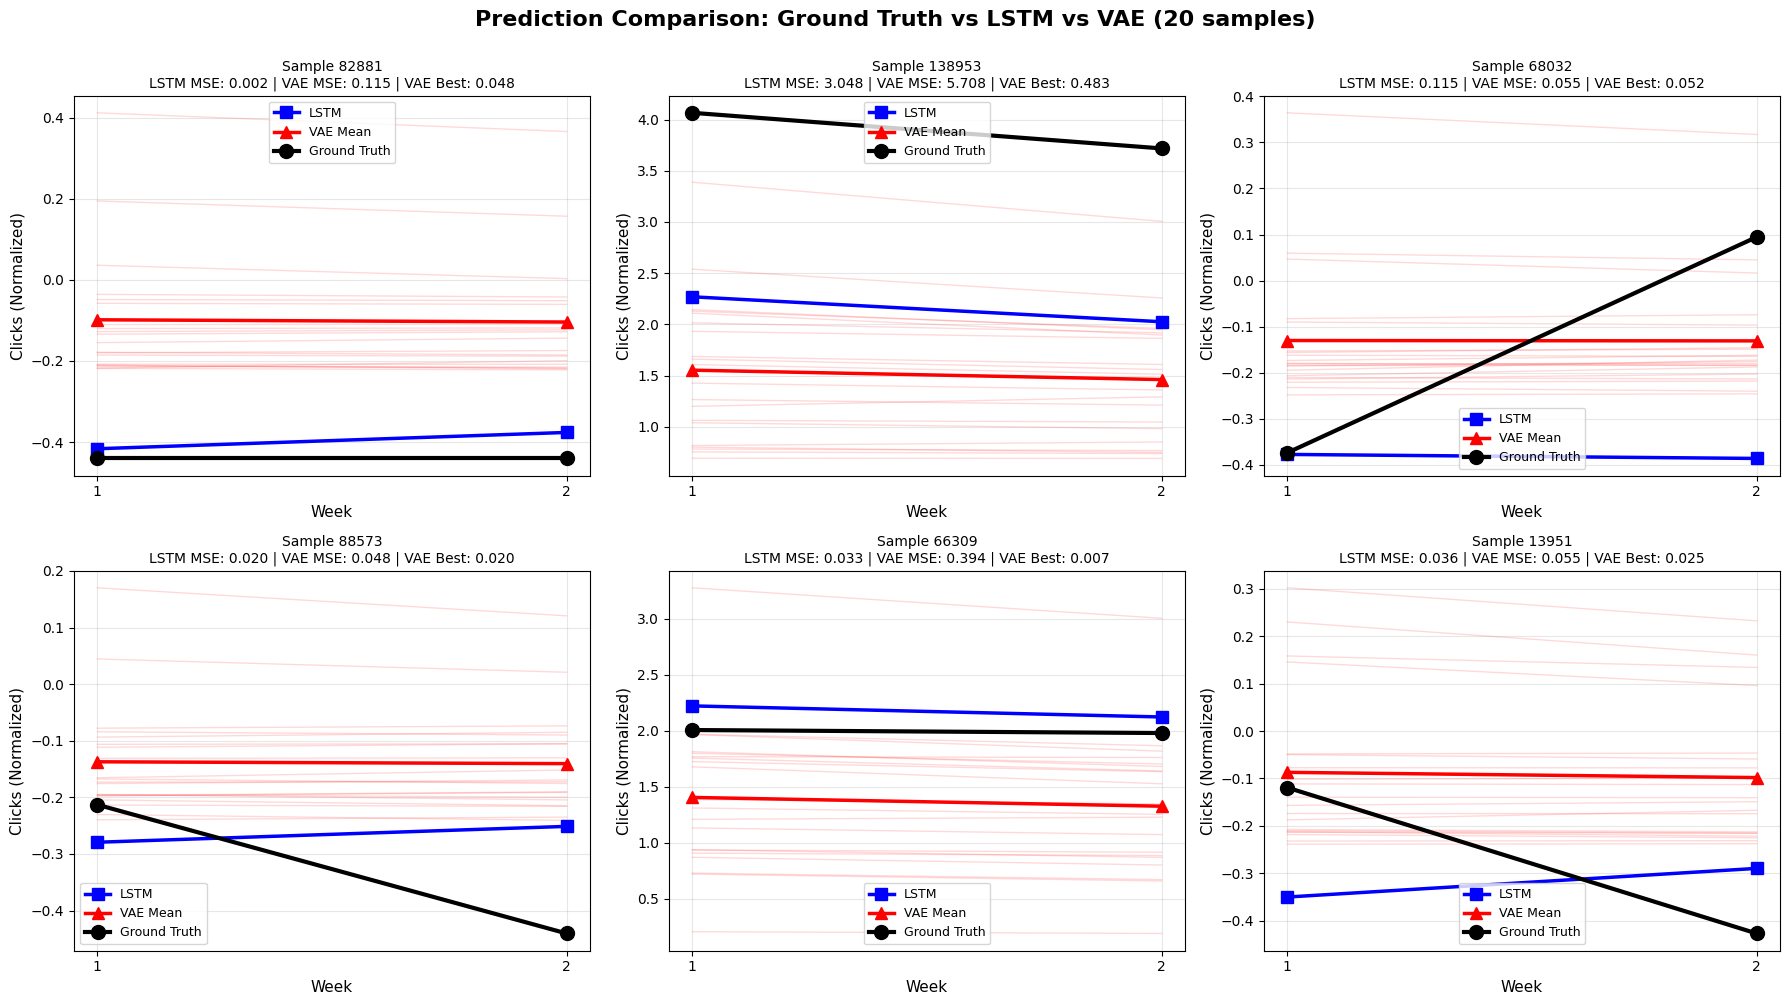

📊 Prediction comparison saved as 'prediction_comparison.png'
Note: Red shaded area shows all 20 VAE samples


In [13]:
"""Visualization 2: Sample Predictions - GT vs LSTM vs VAE"""

import matplotlib.pyplot as plt
import numpy as np

# Select 6 random test samples for visualization
np.random.seed(42)
num_samples = 6
sample_indices = np.random.choice(len(lstm_preds), num_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    ax = axes[idx]

    # Get data for this sample
    gt = y_test[sample_idx].flatten()  # Ground truth (2 weeks)
    lstm_pred = lstm_preds[sample_idx].flatten()
    vae_samples_for_this = vae_all_samples[:, sample_idx]  # Shape: (20, 2, 1)

    # Reshape if needed
    if vae_samples_for_this.ndim == 3:
        vae_samples_for_this = vae_samples_for_this.squeeze(-1)  # (20, 2)

    weeks = np.arange(1, len(gt) + 1)

    # Plot VAE samples (20 semi-transparent lines)
    for i in range(20):
        ax.plot(weeks, vae_samples_for_this[i], color="red", alpha=0.15, linewidth=1)

    # Plot LSTM prediction
    ax.plot(
        weeks, lstm_pred, "b-", linewidth=2.5, label="LSTM", marker="s", markersize=8
    )

    # Plot VAE mean
    vae_mean = vae_samples_for_this.mean(axis=0)
    ax.plot(
        weeks, vae_mean, "r-", linewidth=2.5, label="VAE Mean", marker="^", markersize=8
    )

    # Plot ground truth
    ax.plot(
        weeks, gt, "k-", linewidth=3, label="Ground Truth", marker="o", markersize=10
    )

    # Calculate MSE for this sample
    lstm_mse = np.mean((gt - lstm_pred) ** 2)
    vae_mse = np.mean((gt - vae_mean) ** 2)
    vae_best_mse = min(
        [np.mean((gt - vae_samples_for_this[i]) ** 2) for i in range(20)]
    )

    ax.set_xlabel("Week", fontsize=11)
    ax.set_ylabel("Clicks (Normalized)", fontsize=11)
    ax.set_title(
        f"Sample {sample_idx}\nLSTM MSE: {lstm_mse:.3f} | VAE MSE: {vae_mse:.3f} | VAE Best: {vae_best_mse:.3f}",
        fontsize=10,
    )
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)
    ax.set_xticks([1, 2])

plt.suptitle(
    "Prediction Comparison: Ground Truth vs LSTM vs VAE (20 samples)",
    fontsize=16,
    fontweight="bold",
    y=1.00,
)
plt.tight_layout()
plt.savefig("prediction_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 Prediction comparison saved as 'prediction_comparison.png'")
print(f"Note: Red shaded area shows all 20 VAE samples")

Cell 10: Visualization 3 - VAE Diversity Analysis

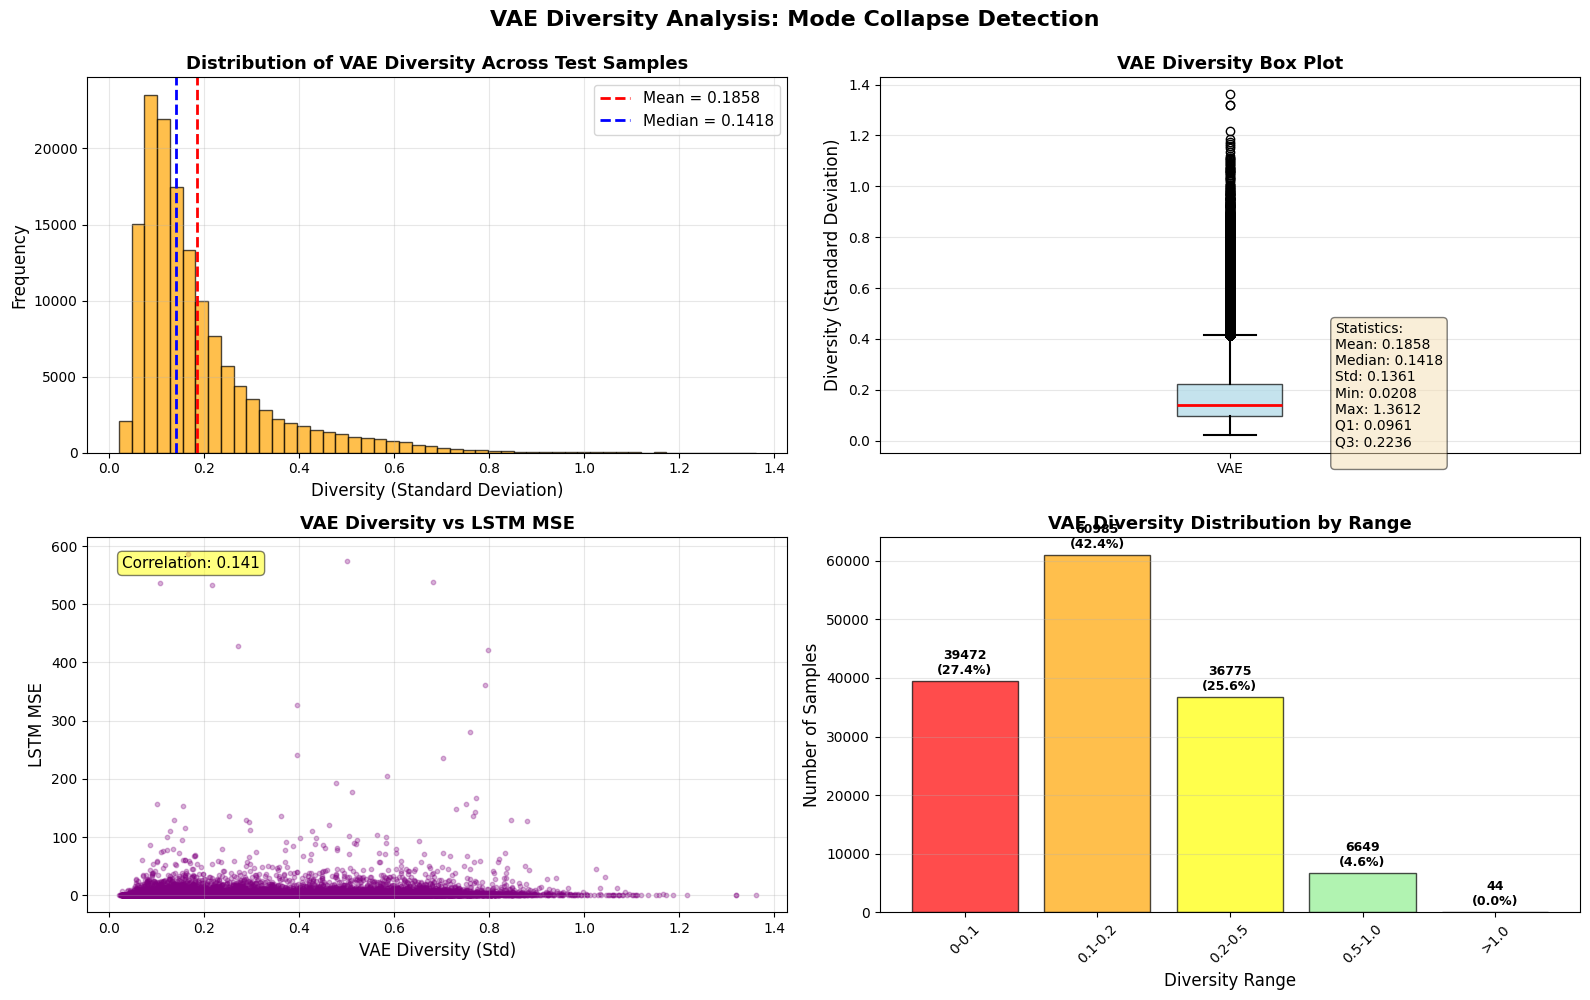

📊 Diversity analysis saved as 'diversity_analysis.png'

🔍 Interpretation:
   - Average diversity: 0.1858
   - 69.8% of samples have diversity < 0.2
   - This indicates SEVERE mode collapse


In [14]:
"""Visualization 3: VAE Diversity Analysis"""

# Calculate diversity (std) for each test sample
diversity_per_sample = []
for i in range(vae_all_samples.shape[1]):  # Iterate over samples
    samples = vae_all_samples[:, i]  # Shape: (20, 2, 1) or (20, 2)
    if samples.ndim == 3:
        samples = samples.squeeze(-1)  # (20, 2)
    diversity = np.std(samples)  # Overall std across all 20 samples
    diversity_per_sample.append(diversity)

diversity_per_sample = np.array(diversity_per_sample)

# Create diversity analysis plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Histogram of diversity
axes[0, 0].hist(
    diversity_per_sample, bins=50, color="orange", alpha=0.7, edgecolor="black"
)
axes[0, 0].axvline(
    diversity_per_sample.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean = {diversity_per_sample.mean():.4f}",
)
axes[0, 0].axvline(
    np.median(diversity_per_sample),
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Median = {np.median(diversity_per_sample):.4f}",
)
axes[0, 0].set_xlabel("Diversity (Standard Deviation)", fontsize=12)
axes[0, 0].set_ylabel("Frequency", fontsize=12)
axes[0, 0].set_title(
    "Distribution of VAE Diversity Across Test Samples", fontsize=13, fontweight="bold"
)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot
axes[0, 1].boxplot(
    [diversity_per_sample],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", alpha=0.7),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(linewidth=1.5),
    capprops=dict(linewidth=1.5),
)
axes[0, 1].set_ylabel("Diversity (Standard Deviation)", fontsize=12)
axes[0, 1].set_title("VAE Diversity Box Plot", fontsize=13, fontweight="bold")
axes[0, 1].set_xticklabels(["VAE"])
axes[0, 1].grid(True, alpha=0.3, axis="y")

# Add statistics text
stats_text = f"""Statistics:
Mean: {diversity_per_sample.mean():.4f}
Median: {np.median(diversity_per_sample):.4f}
Std: {diversity_per_sample.std():.4f}
Min: {diversity_per_sample.min():.4f}
Max: {diversity_per_sample.max():.4f}
Q1: {np.percentile(diversity_per_sample, 25):.4f}
Q3: {np.percentile(diversity_per_sample, 75):.4f}
"""
axes[0, 1].text(
    1.15,
    diversity_per_sample.mean(),
    stats_text,
    fontsize=10,
    verticalalignment="center",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

# 3. Diversity vs LSTM MSE (scatter plot)
axes[1, 0].scatter(
    diversity_per_sample, lstm_mse_per_sample, alpha=0.3, c="purple", s=10
)
axes[1, 0].set_xlabel("VAE Diversity (Std)", fontsize=12)
axes[1, 0].set_ylabel("LSTM MSE", fontsize=12)
axes[1, 0].set_title("VAE Diversity vs LSTM MSE", fontsize=13, fontweight="bold")
axes[1, 0].grid(True, alpha=0.3)

# Add correlation coefficient
correlation = np.corrcoef(diversity_per_sample, lstm_mse_per_sample)[0, 1]
axes[1, 0].text(
    0.05,
    0.95,
    f"Correlation: {correlation:.3f}",
    transform=axes[1, 0].transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.5),
)

# 4. Diversity bins analysis
diversity_bins = [0, 0.1, 0.2, 0.5, 1.0, float("inf")]
diversity_labels = ["0-0.1", "0.1-0.2", "0.2-0.5", "0.5-1.0", ">1.0"]
diversity_binned = pd.cut(
    diversity_per_sample, bins=diversity_bins, labels=diversity_labels
)
diversity_counts = diversity_binned.value_counts().sort_index()

axes[1, 1].bar(
    range(len(diversity_counts)),
    diversity_counts.values,
    color=["red", "orange", "yellow", "lightgreen", "green"],
    alpha=0.7,
    edgecolor="black",
)
axes[1, 1].set_xlabel("Diversity Range", fontsize=12)
axes[1, 1].set_ylabel("Number of Samples", fontsize=12)
axes[1, 1].set_title(
    "VAE Diversity Distribution by Range", fontsize=13, fontweight="bold"
)
axes[1, 1].set_xticks(range(len(diversity_counts)))
axes[1, 1].set_xticklabels(diversity_labels, rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis="y")

# Add percentages on bars
for i, (count, label) in enumerate(zip(diversity_counts.values, diversity_labels)):
    percentage = 100 * count / len(diversity_per_sample)
    axes[1, 1].text(
        i,
        count + max(diversity_counts.values) * 0.02,
        f"{count}\n({percentage:.1f}%)",
        ha="center",
        fontsize=9,
        fontweight="bold",
    )

plt.suptitle(
    "VAE Diversity Analysis: Mode Collapse Detection",
    fontsize=16,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.savefig("diversity_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 Diversity analysis saved as 'diversity_analysis.png'")
print(f"\n🔍 Interpretation:")
print(f"   - Average diversity: {diversity_per_sample.mean():.4f}")
print(
    f"   - {100 * (diversity_per_sample < 0.2).sum() / len(diversity_per_sample):.1f}% of samples have diversity < 0.2"
)
print(
    f"   - This indicates {'SEVERE' if diversity_per_sample.mean() < 0.3 else 'MODERATE' if diversity_per_sample.mean() < 0.5 else 'MILD'} mode collapse"
)

Cell 11: Visualization 4 - Comprehensive Comparison Dashboard

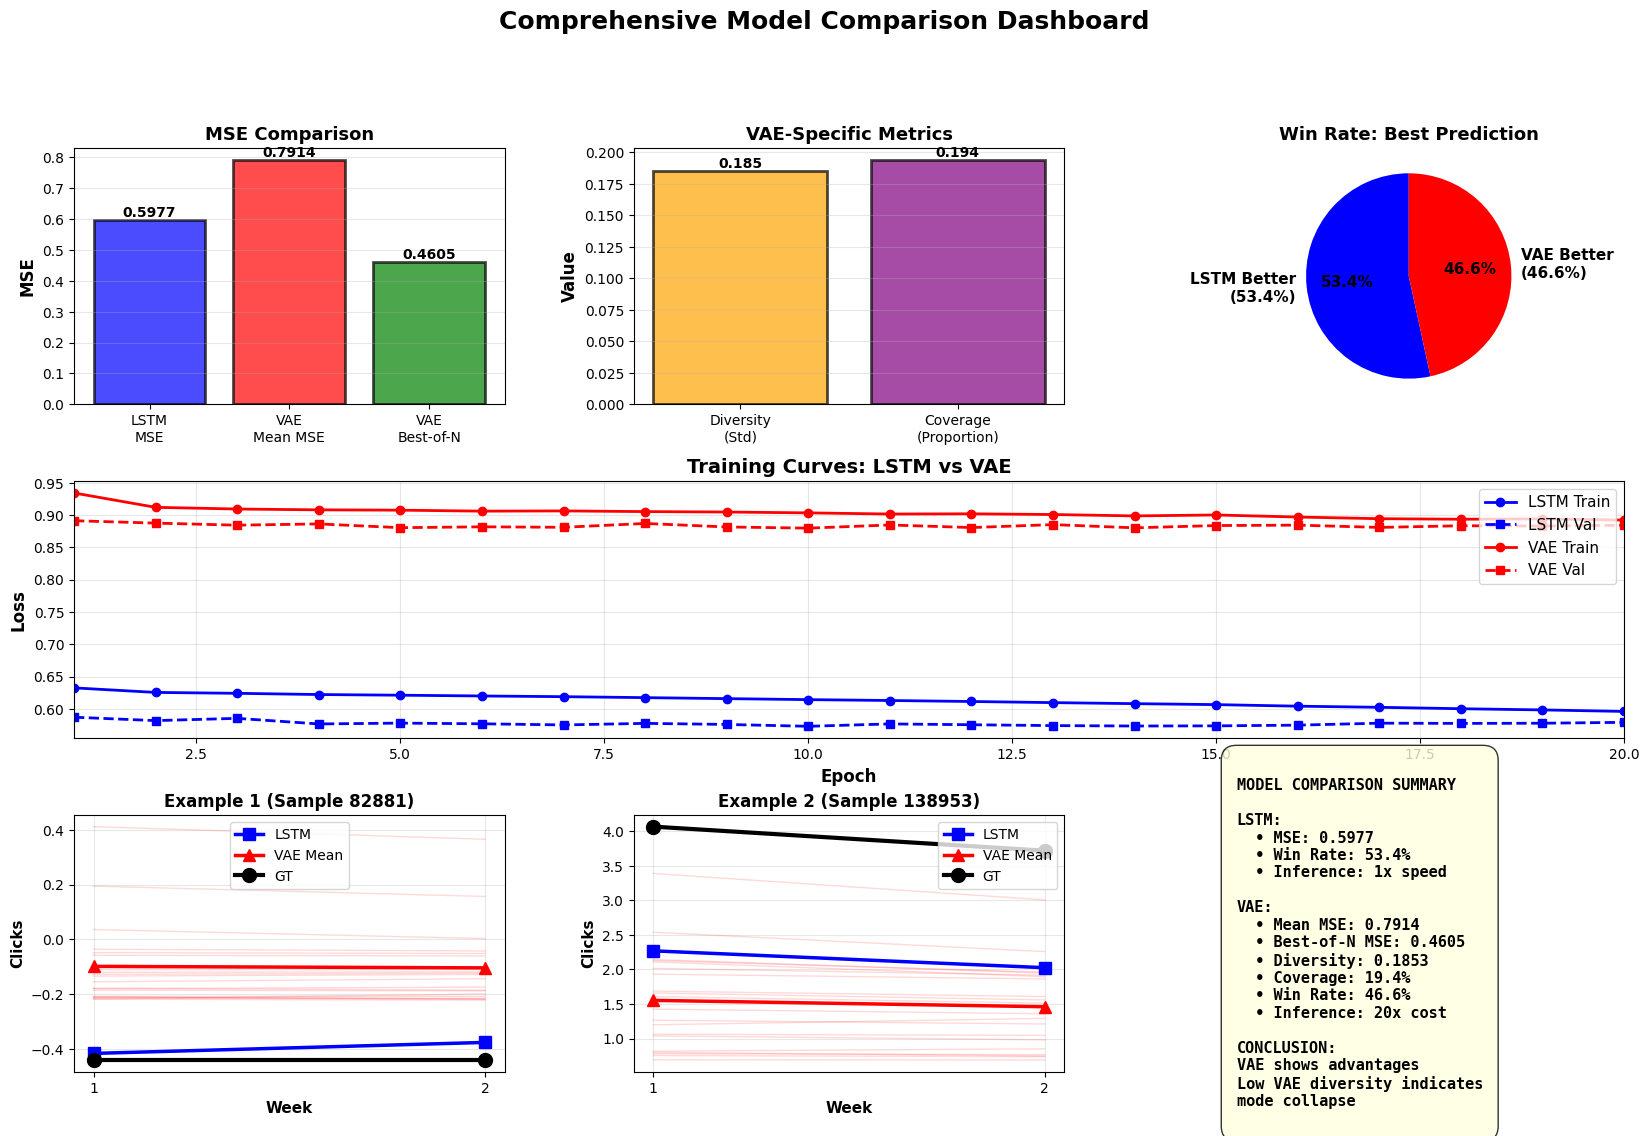

📊 Comprehensive comparison saved as 'comprehensive_comparison.png'

✅ All visualizations complete!
   1. training_curves.png
   2. prediction_comparison.png
   3. diversity_analysis.png
   4. comprehensive_comparison.png


In [15]:
"""Visualization 4: Comprehensive Model Comparison Dashboard"""

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. MSE Comparison
ax1 = fig.add_subplot(gs[0, 0])
mse_data = [results["lstm_mse"], results["vae_mse"], results["vae_best_of_n_mse"]]
colors = ["blue", "red", "green"]
bars = ax1.bar(
    ["LSTM\nMSE", "VAE\nMean MSE", "VAE\nBest-of-N"],
    mse_data,
    color=colors,
    alpha=0.7,
    edgecolor="black",
    linewidth=2,
)
ax1.set_ylabel("MSE", fontsize=12, fontweight="bold")
ax1.set_title("MSE Comparison", fontsize=13, fontweight="bold")
ax1.grid(True, alpha=0.3, axis="y")

# Add values on bars
for bar, value in zip(bars, mse_data):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{value:.4f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

# 2. VAE Metrics
ax2 = fig.add_subplot(gs[0, 1])
vae_metrics = [results["vae_diversity"], results["vae_coverage"]]
metric_names = ["Diversity\n(Std)", "Coverage\n(Proportion)"]
bars = ax2.bar(
    metric_names,
    vae_metrics,
    color=["orange", "purple"],
    alpha=0.7,
    edgecolor="black",
    linewidth=2,
)
ax2.set_ylabel("Value", fontsize=12, fontweight="bold")
ax2.set_title("VAE-Specific Metrics", fontsize=13, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

for bar, value in zip(bars, vae_metrics):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{value:.3f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

# 3. Win Rate Pie Chart
ax3 = fig.add_subplot(gs[0, 2])

# Calculate VAE best-of-N MSE per sample
vae_best_mse_per_sample = []
for i in range(len(y_test)):
    sample_mses = []
    for j in range(20):
        vae_sample = vae_all_samples[j, i]
        if vae_sample.ndim == 2:
            vae_sample = vae_sample.squeeze(-1)
        mse = np.mean((y_test[i] - vae_sample) ** 2)
        sample_mses.append(mse)
    vae_best_mse_per_sample.append(min(sample_mses))

vae_best_mse_per_sample = np.array(vae_best_mse_per_sample)

lstm_win = (lstm_mse_per_sample < vae_best_mse_per_sample).sum()
vae_win = len(y_test) - lstm_win
win_data = [lstm_win, vae_win]
win_labels = [
    f"LSTM Better\n({100 * lstm_win / len(y_test):.1f}%)",
    f"VAE Better\n({100 * vae_win / len(y_test):.1f}%)",
]
ax3.pie(
    win_data,
    labels=win_labels,
    colors=["blue", "red"],
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 11, "fontweight": "bold"},
)
ax3.set_title("Win Rate: Best Prediction", fontsize=13, fontweight="bold")

# 4. Training Curves (Combined)
ax4 = fig.add_subplot(gs[1, :])
epochs = range(1, 21)
ax4.plot(
    epochs,
    lstm_train_losses,
    "b-",
    linewidth=2,
    label="LSTM Train",
    marker="o",
    markersize=6,
)
ax4.plot(
    epochs,
    lstm_val_losses,
    "b--",
    linewidth=2,
    label="LSTM Val",
    marker="s",
    markersize=6,
)
ax4.plot(
    epochs,
    vae_train_losses,
    "r-",
    linewidth=2,
    label="VAE Train",
    marker="o",
    markersize=6,
)
ax4.plot(
    epochs,
    vae_val_losses,
    "r--",
    linewidth=2,
    label="VAE Val",
    marker="s",
    markersize=6,
)
ax4.set_xlabel("Epoch", fontsize=12, fontweight="bold")
ax4.set_ylabel("Loss", fontsize=12, fontweight="bold")
ax4.set_title("Training Curves: LSTM vs VAE", fontsize=14, fontweight="bold")
ax4.legend(fontsize=11, loc="upper right")
ax4.grid(True, alpha=0.3)
ax4.set_xlim(1, 20)

# 5. Sample Predictions (2 examples)
for i, sample_idx in enumerate([sample_indices[0], sample_indices[1]]):
    ax = fig.add_subplot(gs[2, i])

    gt = y_test[sample_idx].flatten()
    lstm_pred = lstm_preds[sample_idx].flatten()
    vae_samples_for_this = vae_all_samples[:, sample_idx]

    if vae_samples_for_this.ndim == 3:
        vae_samples_for_this = vae_samples_for_this.squeeze(-1)

    weeks = np.arange(1, len(gt) + 1)

    # Plot VAE samples
    for j in range(20):
        ax.plot(weeks, vae_samples_for_this[j], "r-", alpha=0.15, linewidth=1)

    ax.plot(
        weeks, lstm_pred, "b-", linewidth=2.5, label="LSTM", marker="s", markersize=8
    )
    ax.plot(
        weeks,
        vae_samples_for_this.mean(axis=0),
        "r-",
        linewidth=2.5,
        label="VAE Mean",
        marker="^",
        markersize=8,
    )
    ax.plot(weeks, gt, "k-", linewidth=3, label="GT", marker="o", markersize=10)

    ax.set_xlabel("Week", fontsize=11, fontweight="bold")
    ax.set_ylabel("Clicks", fontsize=11, fontweight="bold")
    ax.set_title(
        f"Example {i + 1} (Sample {sample_idx})", fontsize=12, fontweight="bold"
    )
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks([1, 2])

# 6. Summary Statistics Table
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis("off")

summary_text = f"""
MODEL COMPARISON SUMMARY

LSTM:
  • MSE: {results["lstm_mse"]:.4f}
  • Win Rate: {100 * lstm_win / len(y_test):.1f}%
  • Inference: 1x speed

VAE:
  • Mean MSE: {results["vae_mse"]:.4f}
  • Best-of-N MSE: {results["vae_best_of_n_mse"]:.4f}
  • Diversity: {results["vae_diversity"]:.4f}
  • Coverage: {results["vae_coverage"]:.1%}
  • Win Rate: {100 * vae_win / len(y_test):.1f}%
  • Inference: 20x cost

CONCLUSION:
{"LSTM clearly outperforms VAE" if results["lstm_mse"] < results["vae_best_of_n_mse"] else "VAE shows advantages"}
{"Low VAE diversity indicates" if results["vae_diversity"] < 0.3 else "VAE diversity is"}
{"mode collapse" if results["vae_diversity"] < 0.3 else "acceptable"}
"""

ax6.text(
    0.1,
    0.5,
    summary_text,
    fontsize=11,
    verticalalignment="center",
    family="monospace",
    fontweight="bold",
    bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8, pad=1),
)

plt.suptitle(
    "Comprehensive Model Comparison Dashboard", fontsize=18, fontweight="bold", y=0.995
)
plt.savefig("comprehensive_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 Comprehensive comparison saved as 'comprehensive_comparison.png'")
print("\n✅ All visualizations complete!")
print("   1. training_curves.png")
print("   2. prediction_comparison.png")
print("   3. diversity_analysis.png")
print("   4. comprehensive_comparison.png")